# Capstone Project: Histopathologic Cancer Detection
Daniel S. Panizzo

Identify metastatic tissue in histopathologic scans of lymph node sections

In [1]:
# Import all libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv

import keras

from glob import glob

%matplotlib inline

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


AttributeError: module 'tensorflow.python.keras.backend' has no attribute 'get_graph'

In [3]:
# Paths to train and test data
train_folder = '.\\train\\'
test_folder = '.\\test\\'

# Prepare a dataframe to store complete path to images and its IDs
df_img = pd.DataFrame({'path': glob(os.path.join(train_folder,'*.tif'))})
df_img['id'] = df_img.path.map(lambda x: x.split('\\')[2].split(".")[0])

# Prepare dataframe with labeled train data
df_train = pd.read_csv('train_labels.csv')

# Join (Merge) dataframes on ID
df = df_train.merge(df_img, on = "id")

# Create a column to represent the image as RGB arrays 
df['rgb'] = df['path'].apply(lambda x: cv.cvtColor(cv.imread(x), cv.COLOR_BGR2RGB))

# Create a column with RGB arrays flattened
# df['flatten'] = df['rgb'].apply(lambda x: x.flatten())

In [4]:
# Quick look at our dataframe
df.head(5)

,id,label,path,rgb
0,00b6e7c821052398e701db1b05c5e0ac212064a1,0,.\train\00b6e7c821052398e701db1b05c5e0ac212064...,"[[[119, 70, 102], [250, 204, 232], [244, 199, ..."
1,00ab7889590888c772b05d5cce945b477913fd1c,1,.\train\00ab7889590888c772b05d5cce945b477913fd...,"[[[157, 113, 192], [129, 72, 151], [184, 116, ..."
2,000ef1b51b71267e85aca599d4def578d870c9e0,1,.\train\000ef1b51b71267e85aca599d4def578d870c9...,"[[[154, 106, 190], [152, 99, 181], [173, 114, ..."
3,00a6372bfddcacceeb76198664a65ff4fecf384f,1,.\train\00a6372bfddcacceeb76198664a65ff4fecf38...,"[[[151, 103, 165], [145, 98, 166], [123, 79, 1..."
4,00b1caf608b2e26137c5ba030d2ef6ec973fe557,0,.\train\00b1caf608b2e26137c5ba030d2ef6ec973fe5...,"[[[67, 20, 40], [63, 3, 29], [170, 93, 127], [..."


In [5]:
def plot_samples(df):
    """
    Function to plot random sample of images.
    Based on the code from Joni Juvonen at:
    https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
    
    Args:
        df (dataframe): A dataframe containing one column with the image as RGB array.
    """
    
    # Define the figure's properties
    fig, ax = plt.subplots(2,5, figsize=(20,8))
    fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

    # Prepare negative samples
    for i, rgb in enumerate(df[df['label'] == 0]['rgb'][:5]):
        ax[0,i].imshow(rgb)
        # Create a Rectangle patch
        box = patches.Rectangle((32,32),32,32
                               ,linewidth = 4
                               ,edgecolor = 'b'
                               ,facecolor = 'none'
                               ,linestyle = ':'
                               ,capstyle = 'round')
        ax[0,i].add_patch(box)
    ax[0,0].set_ylabel('Negative samples', size='large')

    # Prepare positive samples
    for i, rgb in enumerate(df[df['label'] == 1]['rgb'][:5]):
        ax[1,i].imshow(rgb)
        # Create a Rectangle patch
        box = patches.Rectangle((32,32),32,32
                               ,linewidth = 4
                               ,edgecolor = 'r'
                               ,facecolor = 'none'
                               ,linestyle = ':'
                               ,capstyle = 'round')
        ax[1,i].add_patch(box)
    ax[1,0].set_ylabel('Positive samples', size='large')

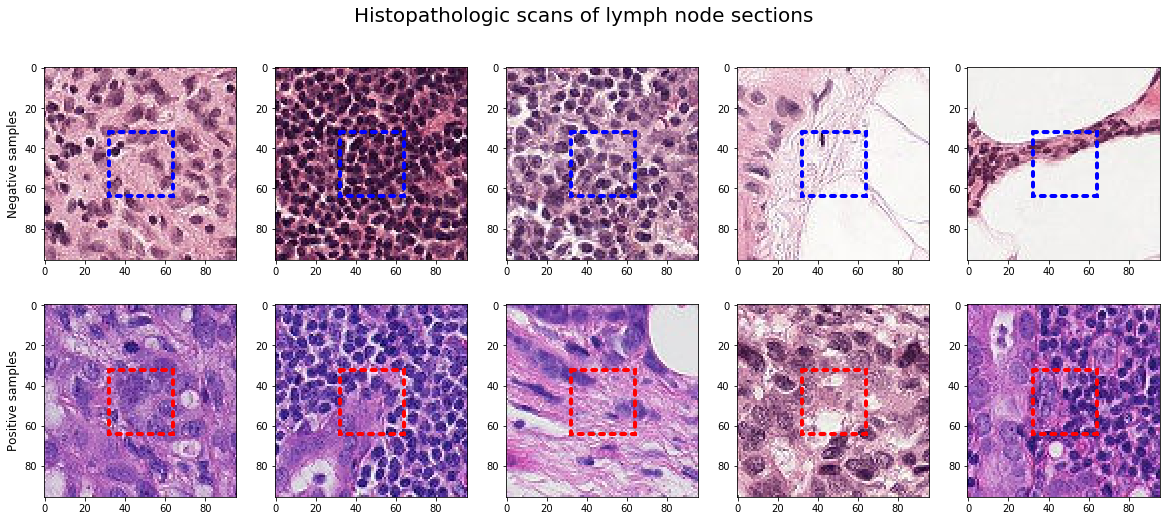

In [6]:
plot_samples(df)

In [7]:
def plot_label_distribution(df):
    """
    Function to plot the frequency of the label distribution.
    Based on the code from Pablo Gomez at:
    https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
    
    Args:
        df (dataframe): A dataframe containing one column with the image label 
                       (Negative == 0 and Positive == 1).
    """
    # Get only the label data
    y = df['label'].copy() 

    # Define the figure's properties
    fig = plt.figure(figsize=(4, 2),dpi=150)

    # Prepare the bar chart data and properties
    plt.bar(y.unique()
           ,[(y == 0).sum()
            ,(y == 1).sum()]
           ); 

    plt.xticks([0,1]
              ,["Negative (N={})".format((y == 0).sum())
               ,"Positive (N={})".format((y == 1).sum())]
              );

    plt.ylabel("# of Samples")

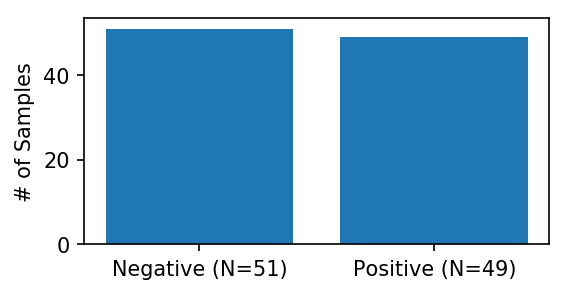

In [8]:
plot_label_distribution(df)

In [23]:
def plot_pixel_distribution(df):
    """
    Function to plot a histogram of the pixel distribution.
    Based on the code from Pablo Gomez and Matplotlib Tutorial:
    https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
    https://matplotlib.org/3.1.1/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py
    
    Args:
        df (dataframe): A dataframe containing one column with image as RGB array
                        and other column with the label (Negative == 0 and Positive == 1)
    
    """
    # Prepare the data 
    positive_samples = df[df['label'] == 1]['rgb']
    negative_samples = df[df['label'] == 0]['rgb']
    
    # Define the number of bins 
    # (all possible pixel values)
    bins = 256 
    
    # Define the figure properties
    fig,axs = plt.subplots(1
                          ,2
                          ,sharey = True
                          ,sharex = True
                          ,figsize=(8,2)
                          ,dpi=150)
    
    # Prepare chart data and properties
    axs[0].hist(positive_samples.ravel()
               ,bins = bins
               ,ec = 'k'
               ,density = True)   
    axs[1].hist(negative_samples.ravel()
               ,bins = bins
               ,ec = 'k'
               ,density=True)
    
    # Prepare chart titles and labels
    axs[0].set_title("Positive samples")
    axs[1].set_title("Negative samples")
    axs[0].set_xlabel("Pixel value")
    axs[1].set_xlabel("Pixel value")
    axs[0].set_ylabel("Relative frequency")
    axs[1].set_ylabel("Relative frequency")

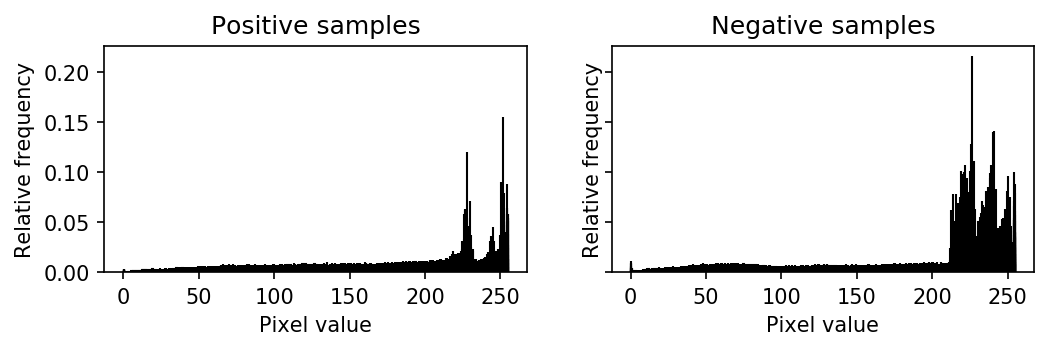

In [24]:
plot_pixel_distribution(df)